# Hydrological Flood‑Hour Classifier – **v2**
*Generated 2025-08-06 22:28*

Updates vs v1:
1. **Flood label** = discharge above each station’s **90ᵗʰ percentile** (data‑driven).
2. Added **1–6 h discharge lags** as features.
3. Uses **BalancedRandomForest** (from `imblearn`) to handle class imbalance.
4. Reports **precision/recall/F1** and **PR‑AUC**.

Run the notebook top‑to‑bottom. If `imblearn` isn’t installed, the code will fall back to a weighted `RandomForestClassifier`.


In [1]:
# Install imbalanced-learn if missing
try:
    import imblearn
except ImportError:
    import subprocess, sys, importlib
    print("⚠️  imbalanced-learn not found – installing...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "imbalanced-learn"])
    importlib.invalidate_caches()


In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier

from imblearn.ensemble import BalancedRandomForestClassifier

# ── CONFIG ──────────────────────────────────────────────────────────────
PROJECT_ROOT = Path.cwd() if (Path.cwd() / 'data').exists() else Path.cwd().parent
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
STATIONS = ['D08A071', 'D08A084', 'D08A115']         # extend as needed
ROLL_WINDOWS = [3, 6, 12]                            # rainfall sums (h)
LAG_HRS = range(1, 7)                                # discharge lags 1–6h
TEST_SPLIT_FRAC = 0.2
PERCENTILE = 0.90                                    # flood threshold per station
# ────────────────────────────────────────────────────────────────────────

def find_csv(code: str) -> Path:
    folder = DATA_RAW / f'station_{code}'
    matches = list(folder.glob('*.csv'))
    assert len(matches) == 1, f"{code}: expected 1 csv, found {matches}"
    return matches[0]

def load_station(code: str) -> pd.DataFrame:
    p = find_csv(code)

    df = pd.read_csv(p)
    df['datetime'] = pd.to_datetime(df['saatlik'])

    df = (
        df.rename(columns={'yagis_toplam': 'rain_mm',
                           'qdeger':       'discharge_cms'})
          .set_index('datetime')        # ← make DatetimeIndex
          .sort_index()
          .resample('h')                # ← now safe
          .agg({'rain_mm': 'sum',
                'discharge_cms': 'mean'})
    )

    df['station'] = code
    return df

In [3]:
# Load & concatenate
frames = [load_station(c) for c in STATIONS]
full = pd.concat(frames, keys=STATIONS, names=['station', 'datetime'])
# ensure regular hourly index within each station block
dupes = full.index.duplicated().sum()
print("Total duplicate timestamps in concatenated DF:", dupes)
full.head()


Total duplicate timestamps in concatenated DF: 0


rain_mm  discharge_cms  station
station datetime                                            
D08A071 2014-01-01 00:00:00      0.0          0.728  D08A071
        2014-01-01 01:00:00      0.0          0.728  D08A071
        2014-01-01 02:00:00      0.0          0.728  D08A071
        2014-01-01 03:00:00      0.0          0.728  D08A071
        2014-01-01 04:00:00      0.0          0.728  D08A071

In [4]:

if 'station' in full.columns:
    full = full.drop(columns='station')

# ── Feature engineering ───────────────────────────────
fe = full.copy()

# rainfall rolling sums
for w in ROLL_WINDOWS:
    fe[f'rain_sum_{w}h'] = (
        fe.groupby(level='station')['rain_mm']          # ← note level=
          .rolling(w, min_periods=1).sum().values
    )

# discharge lags
for l in LAG_HRS:
    fe[f'dis_lag_{l}h'] = (
        fe.groupby(level='station')['discharge_cms']
          .shift(l)
    )

fe = fe.dropna()

In [6]:
# ── Label floods by 90th percentile per station ───────────────────────
# 1) threshold Series indexed by station level
thr = fe.groupby(level='station')['discharge_cms'].quantile(PERCENTILE)

# 2) vectorised comparison
fe['flood'] = (
    fe['discharge_cms'] >
    fe.index.get_level_values('station').map(thr)
).astype(int)

print("Flood-hour counts:", fe['flood'].value_counts().to_dict())

Flood-hour counts: {0: 81322, 1: 8858}


In [7]:
# ── Train/test split (time-based) ──────────────────────────────────────
split_idx = int(len(fe) * (1 - TEST_SPLIT_FRAC))
train, test = fe.iloc[:split_idx], fe.iloc[split_idx:]

FEATURES = [c for c in fe.columns if c.startswith('rain_') or c.startswith('dis_lag')]
X_train, y_train = train[FEATURES], train['flood']
X_test,  y_test  = test[FEATURES],  test['flood']

print('Train shape', X_train.shape, 'Positives', y_train.sum())
print('Test  shape', X_test.shape,  'Positives', y_test.sum())


Train shape (72144, 10) Positives 6371
Test  shape (18036, 10) Positives 2487


In [8]:
# ── Fit model ──────────────────────────────────────────────────────────
try:
    clf = BalancedRandomForestClassifier(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        sampling_strategy='auto'
    )
    model_name = 'BalancedRandomForest'
except Exception as e:
    print("BalancedRandomForest unavailable, falling back to RandomForest with class_weight.")
    clf = RandomForestClassifier(
        n_estimators=400,
        random_state=42,
        class_weight={0:1, 1:len(y_train)/y_train.sum()}   # rough balance
    )
    model_name = 'RandomForestWeighted'

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

print(f"== {model_name} ==")
print(classification_report(y_test, y_pred, digits=3))
print("PR‑AUC:", average_precision_score(y_test, y_prob))

print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


== BalancedRandomForest ==
              precision    recall  f1-score   support

           0      0.984     0.751     0.852     15549
           1      0.372     0.922     0.530      2487

    accuracy                          0.775     18036
   macro avg      0.678     0.836     0.691     18036
weighted avg      0.899     0.775     0.807     18036

PR‑AUC: 0.49207934057559616
Confusion matrix:
 [[11680  3869]
 [  195  2292]]


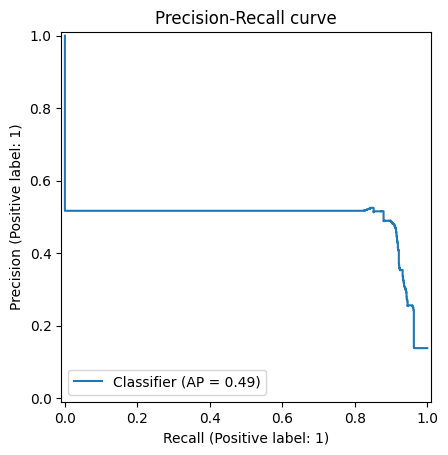

In [9]:
# ── Optional: visualise Precision‑Recall curve ─────────────────────────
disp = PrecisionRecallDisplay.from_predictions(y_test, y_prob)
_ = disp.ax_.set_title("Precision‑Recall curve")


## Next ideas
* Tune `PERCENTILE` (e.g., 0.85 if floods still rare).
* Add rate‑of‑change features: `rain_mm.diff()`, `discharge_cms.diff()`.
* Try GradientBoosting or XGBoost with `scale_pos_weight`.
* If stations behave differently, train per‑station models.
